# Техническая часть

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.3MB/s 


In [ ]:
!pip install -q tensorflow_text

     |████████████████████████████████| 2.6MB 5.3MB/s 


In [ ]:
!git clone https://github.com/DanilDmitriev1999/competitions

Cloning into 'competitions'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 2), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


import lightgbm as lgb

from category_encoders import LeaveOneOutEncoder

from abc import ABCMeta, abstractmethod

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Данные и EDA

In [ ]:
train = pd.read_csv("competitions/task_15/train.csv")
test = pd.read_csv("competitions/task_15/test.csv")

In [ ]:
sb = pd.read_csv("competitions/task_15/sample_submission.csv")
sb.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
test.shape

(100407, 4)

In [ ]:
train.head()

,Brand,Price,Rating,Review,Upvotes
0,Apple,225.0,3,had to return was not unlocked,0.0
1,Nokia,50.0,5,"my contract gonna end next summer, so I need a...",5.0
2,Nokia,150.0,1,It never booited up taught it was the battery ...,0.0
3,BLU,135.0,4,Worth every penny. Great picture quality. Snap...,1.0
4,Apple,240.0,1,"headphone jack does not fit, battery is draine...",1.0


In [ ]:
train.shape

(301075, 5)

In [ ]:
train['Price'].isnull().sum(), train['Brand'].isnull().sum()

(4338, 47469)

In [ ]:
train.isna().any()

Brand       True
Price       True
Rating     False
Review     False
Upvotes    False
dtype: bool

In [ ]:
train.dropna(subset=['Price'], inplace=True)
train = train.fillna('-')
train.shape

(296737, 5)

In [ ]:
len_review = [len(i.split(' ')) for i in train['Review'].values]

print('Min: ', np.min(len_review))
print('Max: ', np.max(len_review))
print('75q: ', np.quantile(len_review, 0.75))
print('95q: ', np.quantile(len_review, 0.95))

Min:  1
Max:  5313
75q:  42.0
95q:  152.0


In [ ]:
train['Brand'] = train.apply(lambda r: r['Brand'].lower(), axis=1)

In [ ]:
train['Brand'].value_counts()

samsung               49286
-                     46098
blu                   44371
apple                 42088
lg                    16292
                      ...  
kingzone                  1
moxee technologies        1
ssiony                    1
tivax                     1
s7 active                 1
Name: Brand, Length: 321, dtype: int64

In [ ]:
def cut_str(string):
    string_list = string.split(' ')[0:350]
    return ' '.join(string_list)

train['Review'] = train.apply(lambda r: cut_str(r['Review']), axis=1)

## categorical features

In [ ]:
enc = LeaveOneOutEncoder()
train['Brand'] = enc.fit_transform(train['Brand'], train['Price'])

In [ ]:
train.head()

,Brand,Price,Rating,Review,Upvotes
0,306.139307,225.0,3,had to return was not unlocked,0.0
1,155.105101,50.0,5,"my contract gonna end next summer, so I need a...",5.0
2,155.096793,150.0,1,It never booited up taught it was the battery ...,0.0
3,247.180640,135.0,4,Worth every penny. Great picture quality. Snap...,1.0
4,306.138950,240.0,1,"headphone jack does not fit, battery is draine...",1.0


In [ ]:
train['Rating'].value_counts()

5    161398
1     51237
4     43964
3     22582
2     17556
Name: Rating, dtype: int64

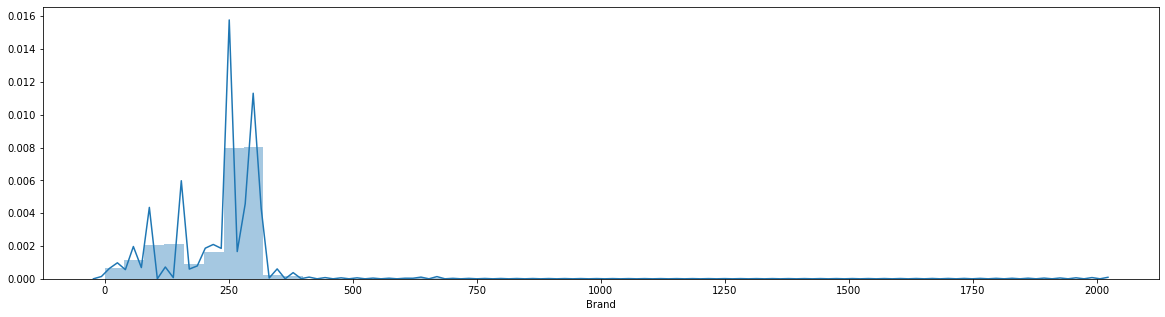

In [ ]:
plt.figure(figsize=(20, 5))
sns.distplot(train['Brand'])

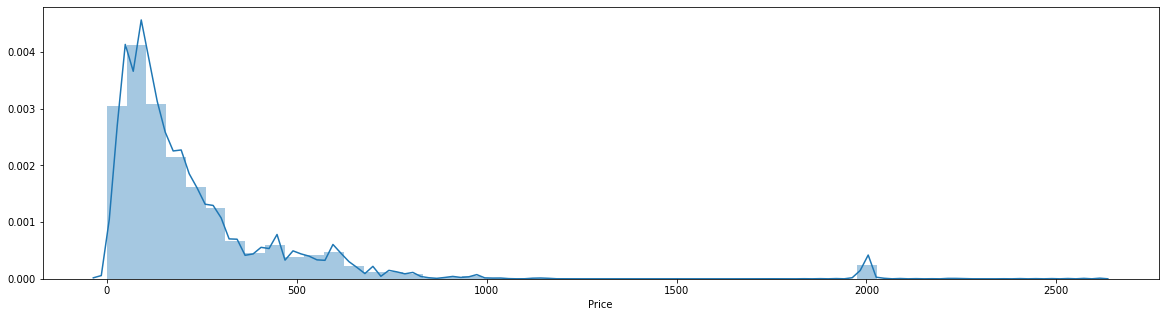

In [ ]:
plt.figure(figsize=(20, 5))
sns.distplot(train['Price'])

## USE

In [ ]:
class TFEncoder(metaclass=ABCMeta):
    def __init__(self, model_path:str):
        self.model = hub.load(model_path)
    
    @abstractmethod
    def encode(self, text:list):
        """Encodes text.
        Text: should be a list of strings to encode
        """
        
class USE(TFEncoder):
    """Universal sentence encoder"""
    def __init__(self, model_path):
        super().__init__(model_path)
        
    def encode(self, text):
        return self.model([text]).numpy()

In [ ]:
model_path = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder = USE(model_path)

In [ ]:
review_encode = [encoder.encode(i) for i in train['Review'].values]

In [ ]:
print()

In [ ]:
train['Review'] = train.apply(lambda r: encoder.encode(r['Review'])[0], axis=1) # apply оч долго работает
train.head()

,Brand,Price,Rating,Review,Upvotes
0,306.139307,225.0,3,"[-0.07336095, -0.046609696, 0.0015336191, 0.00...",0.0
1,155.053696,50.0,5,"[-0.020735564, -0.06908073, -0.051591087, 0.04...",5.0
2,155.045371,150.0,1,"[-0.025030948, -0.05005481, -0.023765707, -0.0...",0.0
3,247.189338,135.0,4,"[0.03589717, -0.044671144, -0.051232487, -0.03...",1.0
4,306.138950,240.0,1,"[-0.045904014, -0.01622993, 0.048226457, 0.044...",1.0


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train['Review'].values,
                                                      train['Rating'].values,
                                                      test_size=0.25)

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_valid, label=y_valid)

NameError: ignored

In [ ]:
params = {
        'num_leaves': 31,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'max_depth': 5,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'rmse',
}

lgr = lgb.LGBMRegressor(**params)

In [ ]:
lgr.fit(X_train.tolist(), y_train.tolist(), eval_set=[(X_valid.tolist(), y_valid.tolist())])

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7f5fc01119b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/distributed/utils_perf.py", line 178, in _gc_callback
tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:41821, threads: 1>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/psutil/_pslinux.py", line 1508, in wrapper
    return fun(self, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/psutil/_pslinux.py", line 1721, in memory_info
    with open_binary("%s/%s/statm" % (self._procfs_path, self.pid)) as f:
  File "/usr/local/lib/python3.6/dist-packages/psutil/_common.py", line 582, in open_binary
    return open(fname, "rb", **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: '/proc/2658/statm'

During handling of the above exception, another exception occurre

In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 4.9MB/s 
     |████████████████████████████████| 1.1MB 23.5MB/s 
     |████████████████████████████████| 890kB 42.0MB/s 
     |████████████████████████████████| 3.0MB 45.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0cd4e2d233356fc91d1a7f0a0e2045261743d3b4bf3630b224709092da45b413
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Попробуем по review предсказывать класс

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train['Review'].values,
                                                      train['Rating'].values,
                                                      test_size=0.25)

In [ ]:
svm_model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1, 3))),
    ('log_regression', LinearSVC())
])

svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_valid)

print('R2-score = {:.2%}'.format(r2_score(y_valid, preds)))
print('MSE-score = {}'.format(mean_squared_error(y_valid, preds)))

R2-score = 84.76%
R2-score = 84.76%
MSE-score = 0.3626474354653906


In [ ]:
print()

In [ ]:
log_reg_model_ = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1, 4))),
    ('log_regression', LogisticRegression(C=10, solver='saga',
                        multi_class='multinomial'))
])

log_reg_model_.fit(X_train, y_train)
preds = log_reg_model_.predict(X_valid)

print('R2-score = {:.2%}'.format(r2_score(y_valid, preds)))
print('MSE-score = {}'.format(mean_squared_error(y_valid, preds)))

R2-score = 85.15%
MSE-score = 0.35343899879100293


### Submit

In [ ]:
len_review = [len(i.split(' ')) for i in test['Review'].values]

print('Min: ', np.min(len_review))
print('Max: ', np.max(len_review))
print('75q: ', np.quantile(len_review, 0.75))
print('95q: ', np.quantile(len_review, 0.95))

Min:  1
Max:  3196
75q:  42.0
95q:  152.0


In [ ]:
test['Review'] = test.apply(lambda r: cut_str(r['Review']), axis=1)

In [ ]:
test.shape

(100407, 4)

In [ ]:
test.head(2)

,Brand,Price,Review,Upvotes
0,SAMSUNG,210.0,This phone is just great. It is faster than an...,1.0
1,Apple,160.0,I was so skeptical to buy a used phone off her...,0.0


In [ ]:
log_reg_model_final = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1, 3))),
    ('log_regression', LogisticRegression(C=10, solver='saga',
                        multi_class='multinomial'))
])

log_reg_model_final.fit(train['Review'].values, train['Rating'].values)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('log_regression',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, in

In [ ]:
preds_final = log_reg_model_final.predict(test['Review'].values)

In [ ]:
my_submit['0'].value_counts()

5    58583
1    18728
4    11829
3     6472
2     4795
Name: 0, dtype: int64

In [ ]:
my_submit = pd.DataFrame({'0': preds_final})
my_submit.head()

,0
0,5
1,5
2,5
3,5
4,5


In [ ]:
my_submit.to_csv('baseline_15.csv', index=False)

# анализ тональности

In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 24.7MB/s 
     |████████████████████████████████| 3.0MB 40.4MB/s 
     |████████████████████████████████| 890kB 49.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e5de26a3fb98c89dc493716934cc675fb6c0485a1d0c8fd4fd6b106f4be93cc5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import collections
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import random
import bz2
import re

import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, RandomSampler, TensorDataset

from transformers import DistilBertModel, DistilBertTokenizer

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_text_dwld = drive.CreateFile({'id':'1I9vf6z80Pjs4oou2WJE728s4HpiFR1qm'})
train_text_dwld.GetContentFile('train.ft.txt.bz2')

In [ ]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for count, line in enumerate(bz2.BZ2File(file)):
        x = line.decode("utf-8")
        if len(x[10:].strip().split(' ')) < 200:
            texts.append(x[10:].strip())
            labels.append(int(x[9]) - 1)
            count +=1

        if count > 90000:
            return labels, texts

In [ ]:
labels, texts = get_labels_and_texts('train.ft.txt.bz2')

In [ ]:
len_snt = [len(i.split(' ')) for i in texts]
np.max(len_snt)

199

In [ ]:
text_train, text_val, label_train, label_val = train_test_split(texts, labels,
                                                    test_size=0.3, random_state=40)

In [ ]:
class CreateDataset(Dataset):

  def __init__(self, sentence, targets, tokenizer, max_len):
    self.sentence = sentence
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentence)
  
  def __getitem__(self, item):
    sentence = str(self.sentence[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def create_data_loader(dt, tokenizer, max_len, batch_size):
  ds = CreateDataset(
    sentence=dt['sentence'],
    targets=dt['label'],
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:
train_dataEng = {'sentence':[i for i in text_train],
              'label':[i for i in label_train]}
val_dataEng = {'sentence':[i for i in text_val],
              'label':[i for i in label_val]}

BATCH_SIZE = 16
MAX_LEN = 350

train_data_loader_eng = create_data_loader(train_dataEng, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader_eng = create_data_loader(val_dataEng, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, hidden_dim=256, bidirectional=True, num_layers=1):
    super(SentimentClassifier, self).__init__()
    self.bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

    self.rnn = nn.GRU(768, hidden_dim, bidirectional=bidirectional,
                      num_layers=num_layers, batch_first=True,
                      dropout = 0 if num_layers < 2 else 0.1)
    
    self.drop = nn.Dropout(p=0.1)
    self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
  
  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]

    output = self.drop(bert_output)

    _, hidden = self.rnn(output)

    output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
    output = self.linear(output)

    return output

In [ ]:
def do_epoch(model, criterion, data, optimizer=None, name=None):
    epoch_loss = 0
    epoch_f1 = 0

    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for batch in data:
                text = batch["input_ids"].to(device)
                targets = batch["targets"].to(device)
                mask = batch["attention_mask"].to(device)

                torch.cuda.empty_cache()
                outputs = model(
                    input_ids=text,
                    attention_mask=mask
                                ).squeeze(1)

                preds = torch.round(torch.sigmoid(outputs))

                loss = criterion(outputs.float(), targets.float())
                
                f1 = f1_score(targets.cpu().detach().numpy(), preds.cpu().detach().numpy())


                epoch_loss += loss.item()
                epoch_f1 += f1

                if optimizer:
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Average Loss = {:.5f}, F1-score = {:.3%}'.format(
                    name, loss , f1))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}, F1-score = {:.3%}'.format(
                name, epoch_loss / batches_count, epoch_f1 / batches_count))

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_data, epochs_count=1,
        val_data=None):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_data, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, None, name_prefix + '  Val:')

In [ ]:
hidden_dim = 128
model = SentimentClassifier(hidden_dim)
model = model.to(device)

EPOCHS = 1

optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss().to(device)
fit(model, criterion, optimizer, train_data=train_data_loader_eng,
    epochs_count=EPOCHS, val_data=val_data_loader_eng)

[1 / 1] Train: Average Loss = 0.28218, F1-score = 88.227%: 100%|██████████| 2187/2187 [24:26<00:00,  1.49it/s]
[1 / 1]   Val: Average Loss = 0.27100, F1-score = 90.672%: 100%|██████████| 938/938 [03:11<00:00,  4.91it/s]


## Заменить review на оценку тональности

In [ ]:
def predict_bert(text, model):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
        )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask).squeeze(1)
    # preds = torch.round(torch.sigmoid(output))
    return output.detach().cpu().numpy()

In [ ]:
train['Review'][4], train['Rating'][4]

('headphone jack does not fit, battery is drained, audio is bad.', 1)

In [ ]:
predict_bert('had to return was not unlocked', model)

Sentiment :[-4.7391534]


In [ ]:
predict_bert(train['Review'][1], model)

Sentiment :[5.027976]


In [ ]:
predict_bert(train['Review'][4], model)

Sentiment :[-4.963832]


In [ ]:
train['Review_sentimen'] = train.apply(lambda r: predict_bert(r['Review'], model), axis=1)

KeyboardInterrupt: ignored

ДОЛГО!

# Анализ тональности на tf-idf + logreg

In [ ]:
text_train, text_val, label_train, label_val = train_test_split(texts, labels,
                                                    test_size=0.3, random_state=40)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import r2_score

In [ ]:
logreg_model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1, 3))),
    ('log_regression', LogisticRegression())
])

logreg_model.fit(text_train, label_train)
pred_lg = logreg_model.predict(text_val)
print('f1: ', f1_score(label_val, pred_lg))

f1:  0.9001948473695605


In [ ]:
text = 'it"s bad!'
logreg_model.predict(text_val)

In [ ]:
text = 'it"s bad!'
logreg_model.predict_proba([text])[0][1]

0.021600148147441028

In [ ]:
train['Review'].shape

(296737,)

In [ ]:
review_sentiment = logreg_model.predict_proba(train['Review'].values)
review_senti = [i[1] for i in review_sentiment]

In [ ]:
len(review_senti)

296737

In [ ]:
train['Sentiment'] = review_senti

In [ ]:
train['Sentiment'].isnull().sum()

0

In [ ]:
train.head(3)

,Brand,Price,Rating,Review,Upvotes,Sentiment
0,306.139307,225.0,3,had to return was not unlocked,0.0,0.008118
1,155.105101,50.0,5,"my contract gonna end next summer, so I need a...",5.0,0.811425
2,155.096793,150.0,1,It never booited up taught it was the battery ...,0.0,0.189341


In [ ]:
X = train.drop(['Rating', 'Review'], axis=1)
y = train['Rating']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_valid, label=y_valid)

In [ ]:
y.value_counts()

5    161398
1     51237
4     43964
3     22582
2     17556
Name: Rating, dtype: int64

In [ ]:
params = {
        "objective" : "binary",
        "metric" : "binary_logloss",
        'max_depth':25,
        "num_leaves" : 20,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        'importance_type':'gain',
        "seed": 42
    }


lgr = lgb.train(params, train_data, 10000,
                valid_sets=[train_data, test_data],
                verbose_eval=500)

[500]	training's l2: 0.900347	valid_1's l2: 0.902358
[1000]	training's l2: 0.883799	valid_1's l2: 0.886794
[1500]	training's l2: 0.879761	valid_1's l2: 0.884104
[2000]	training's l2: 0.877433	valid_1's l2: 0.882993
[2500]	training's l2: 0.874868	valid_1's l2: 0.88152
[3000]	training's l2: 0.872933	valid_1's l2: 0.880389
[3500]	training's l2: 0.871234	valid_1's l2: 0.87958
[4000]	training's l2: 0.869491	valid_1's l2: 0.87853
[4500]	training's l2: 0.867934	valid_1's l2: 0.877744
[5000]	training's l2: 0.86658	valid_1's l2: 0.876959
[5500]	training's l2: 0.865103	valid_1's l2: 0.87609
[6000]	training's l2: 0.863816	valid_1's l2: 0.87529
[6500]	training's l2: 0.862765	valid_1's l2: 0.874752
[7000]	training's l2: 0.861778	valid_1's l2: 0.87424
[7500]	training's l2: 0.860898	valid_1's l2: 0.873777
[8000]	training's l2: 0.86003	valid_1's l2: 0.873403
[8500]	training's l2: 0.859342	valid_1's l2: 0.873221
[9000]	training's l2: 0.858718	valid_1's l2: 0.872996
[9500]	training's l2: 0.857942	valid_

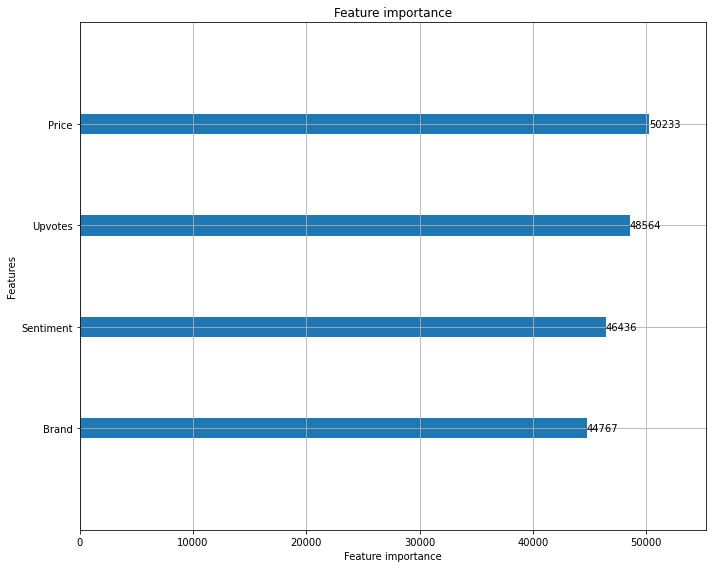

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(lgr, ax=ax)
fig.tight_layout()

In [ ]:
pred_test_y = lgr.predict(X_valid, num_iteration=lgr.best_iteration)

In [ ]:
print('R2-score = {:.2%}'.format(r2_score(y_valid, pred_test_y)))

R2-score = 60.33%


# Ладно, PyTorch

Попробуем чисто по отзывам предсказывать класс.

In [ ]:
import torch
from torchtext import data as data_torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from tqdm import tqdm

import logging
logging.basicConfig(level=logging.ERROR)

device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
TEXT = data_torch.Field(tokenize = 'spacy', sequential=True, lower=True, batch_first=True)
LABEL = data_torch.LabelField(dtype = torch.float, batch_first=True)

In [ ]:
a=['1', '2']
a+=['3', '5']
a

['1', '2', '3', '5']

In [ ]:
def str_plus(string):
    str_split = string.split(' ')
    if len(str_split) < 5:
        str_split += ['0', '0', '0', '0']
        return ' '.join(str_split)
    return string

train['Review'] = train.apply(lambda r: str_plus(r['Review']), axis=1)

In [ ]:
len_review = [len(i.split(' ')) for i in train['Review'].values]

print('Min: ', np.min(len_review))

Min:  5


In [ ]:
dt_train, dt_valid = train_test_split(train, test_size=0.25)
dt_train.head()

,Brand,Price,Rating,Review,Upvotes
265715,BlackBerry,25.0,5,"bought this phone for my son, he loves it . so...",0.0
100180,Motorola,110.0,3,A little old to buy in 2015 but still a good p...,0.0
288602,BLU,100.0,4,Good Thanks 0 0 0 0,0.0
297056,Nokia,130.0,1,dont waste your time buying this phone to use ...,3.0
285941,Samsung,530.0,5,Perfect!!!! 0 0 0 0,0.0


In [ ]:
class DataFrameDataset(data_torch.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.Rating if not is_test else None
            text = row.Review
            examples.append(data_torch.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=dt_train, val_df=dt_valid)

In [ ]:
print(vars(train_ds[-1]))

{'text': ['great', 'product', '!', 'would', 'do', 'business', 'with', 'them', 'again', '.'], 'label': 5}


In [ ]:
print(vars(val_ds[1]))

{'text': ['love', 'it', '.', 'i', 'upgraded', 'from', 'note', '2', '.', 'the', '4', 'holds', 'better', 'battery', 'charge', '.', 'nicer', 'pictures', '.', 'i', 'love', 'it', '☺'], 'label': 5}


In [ ]:
len(train_ds)

222552

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_ds)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f03e48ae598>, {5: 0, 1: 1, 4: 2, 3: 3, 2: 4})


In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator = data_torch.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    device = device)

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat = self.dropout(torch.cat(pooled, dim = 1))
            
        return self.linear(cat)

In [ ]:
k = 0
for i in valid_iterator:
    k += 1
    if k == 17:
        break

In [ ]:
i.text.shape

torch.Size([64, 337])

In [ ]:
test_1.label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 2., 2., 1., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 2., 0., 0., 0., 0., 2.], device='cuda:0')

In [ ]:
outputs = model(test_1.text)
loss = criterion(outputs, test_1.label.long())
loss

tensor(1.5342, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
def draw_graph(train_hist, test_hist):
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1)
    plt.plot(train_hist, label="train")
    plt.title('train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(test_hist)
    plt.title('val loss')
    plt.show()

def do_epoch(model, criterion, data, optimizer=None, name=None):
    epoch_loss = []
    epoch_f1 = 0
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for batch in data:
                texts = batch.text
                targets = batch.label

                torch.cuda.empty_cache()
                outputs = model(texts)

                # print()
                # print(F.log_softmax(outputs))
                # print(targets)
                # out = outputs.cpu().detach()

                loss = criterion(outputs, batch.label.long())
                
                # f1 = f1_score(targets.cpu().detach().numpy(), preds.cpu().detach().numpy())
                pred = outputs.argmax(dim = 1, keepdim = True)
                r2 = r2_score(targets.cpu().detach().numpy(), pred.cpu().detach().numpy())


                epoch_loss.append(loss.item())
                epoch_f1 += r2

                if optimizer:
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                    optimizer.step()
                    optimizer.zero_grad()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Average Loss = {:.5f}, R2-score = {}'.format(
                    name, loss , r2))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}, R2-score = {}'.format(
                name, np.mean(epoch_loss), epoch_f1 / batches_count))

    return epoch_loss


def fit(model, criterion, optimizer, train_data, epochs_count=1,
        val_data=None):
    train_all_loss = []
    val_all_loss = []
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_data, optimizer, name_prefix + 'Train:')
        train_all_loss += train_loss

        
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, None, name_prefix + '  Val:')
            val_all_loss += val_loss

    draw_graph(train_all_loss, val_all_loss)

In [ ]:
input = len(TEXT.vocab)
emb_dim = 100
n_filters = 100
filter_sizes = [1,2,3,4]
output = len(LABEL.vocab) # 5
dropout = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(input, emb_dim, n_filters, filter_sizes, output, dropout, PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.9062,  0.1489,  1.0840,  ..., -2.5114, -0.5024,  0.0939],
        [ 0.1793, -0.3498, -1.8260,  ..., -0.0373,  0.8949,  0.7836],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 1.7458,  1.5830, -0.4088,  ..., -0.8971, -0.9683,  1.5796],
        [ 0.2860, -1.1256, -0.6765,  ..., -0.0881,  1.1699,  0.5293],
        [ 0.1958,  0.4260, -0.9151,  ..., -0.9078, -0.7323,  0.1616]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(emb_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(emb_dim)

In [ ]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss().to(device)

model = model.to(device)

EPOCHS = 5

fit(model, criterion, optimizer, train_iterator, EPOCHS, valid_iterator)